In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
bo_mojo = pd.read_csv('unzippedData/bom.movie_gross.csv')

In [3]:
the_numbers = pd.read_csv('unzippedData/tn.movie_budgets.csv')

In [ ]:
#in the-numbers:
#convert release date to date format
#convert dollar figures to int format

the_numbers['release_date']=pd.to_datetime(the_numbers['release_date'])
the_numbers['production_budget'] = the_numbers['production_budget'].str.replace(',', '').str.replace('$', '').astype(int)
the_numbers['domestic_gross'] = the_numbers['domestic_gross'].str.replace(',', '').str.replace('$', '').astype(int)
the_numbers['worldwide_gross'] = the_numbers['worldwide_gross'].str.replace(',', '').str.replace('$', '').astype(int)

In [5]:
#add column for worldwide profitability
the_numbers['Worldwide Profitability'] = the_numbers['worldwide_gross']/the_numbers['production_budget']

In [6]:
#add column for domestic profitability
the_numbers['Domestic Profitability'] = the_numbers['domestic_gross']/the_numbers['production_budget']

In [7]:
imdb_title_basics=pd.read_csv('unzippedData/imdb.title.basics.csv') #movie title, year, runtime, genre

In [8]:
#in imdb-title-basics:
#only movies aafter 2009
imdb_title_basics=imdb_title_basics[imdb_title_basics['start_year']>2009] 

In [9]:
#cut out movies less than 75 minutes, more than 4 hours
imdb_title_basics=imdb_title_basics[~(imdb_title_basics['runtime_minutes']>240) & ~(imdb_title_basics['runtime_minutes']<75)]

In [10]:
#drop all duplicate movie titles
imdb_title_basics = imdb_title_basics.drop_duplicates('primary_title', keep=False)

In [11]:
#change imdb-title-basics column name to align with 'the-numbers' data
imdb_title_basics.rename(columns={'primary_title':'movie'}, inplace=True)

In [12]:
#make only one genre entry per column
imdb_title_basics['Genre 1']=imdb_title_basics['genres'].str.split(',', expand=True)[0]
imdb_title_basics['Genre 2']=imdb_title_basics['genres'].str.split(',', expand=True)[1]
imdb_title_basics['Genre 3']=imdb_title_basics['genres'].str.split(',', expand=True)[2]

In [13]:
#compile set of genres
genres_1 = list(imdb_title_basics['Genre 1'].unique())
genres_2 = list(imdb_title_basics['Genre 2'].unique())
genres_3 = list(imdb_title_basics['Genre 3'].unique())
genre_set = set(genres_1 + genres_2 + genres_3)

In [14]:
the_numbers.set_index('movie', inplace=True)

In [15]:
imdb_title_basics.set_index('movie', inplace=True, drop=False)

In [16]:
#the-numbers joined with IMDB-title-basics
joined_df = the_numbers.join(imdb_title_basics, how='left') 

In [17]:
#READ IN THIRD DATASET: IMDB-TITLE-RATINGS
imdb_title_ratings=pd.read_csv('unzippedData/imdb.title.ratings.csv') #average rating, number of votes

In [18]:
#prepare to combine imdb-title-basics and imdb-title-ratings
imdb_title_basics.set_index('tconst', inplace=True)
imdb_title_ratings.set_index('tconst', inplace=True)

In [19]:
imdb_combined = imdb_title_ratings.join(imdb_title_basics, how='left') #IMDB-title-ratings + IMDB-title-basics
#imdb_combined.head()

In [20]:
#imdb_combined['movie'].value_counts() #now have ratings and movie names in same Dataframe

In [21]:
#can now add earnings/budget information from the-numbers
imdb_combined.set_index('movie', inplace=True)
imdb_combined.info() #~73000 entries
#the_numbers.info() #5782 entries

<class 'pandas.core.frame.DataFrame'>
Index: 73856 entries, Laiye Je Yaarian to Sathru
Data columns (total 9 columns):
averagerating      73856 non-null float64
numvotes           73856 non-null int64
original_title     56637 non-null object
start_year         56637 non-null float64
runtime_minutes    49709 non-null float64
genres             56080 non-null object
Genre 1            56080 non-null object
Genre 2            28643 non-null object
Genre 3            14361 non-null object
dtypes: float64(3), int64(1), object(5)
memory usage: 5.6+ MB


In [22]:
#combine the-numbers with the combined IMDB data
the_numbers_imdb_combined = the_numbers.join(imdb_combined, how='left')


In [23]:
#the_numbers_imdb_combined.info() #5,782 entries for seasonality vs profitability. otherwise, just ~1,600

In [24]:
#remove entries that were only from the-numbers and not IMDB
the_numbers_imdb_combined2=the_numbers_imdb_combined[the_numbers_imdb_combined['averagerating'].isna()==False]
#the_numbers_imdb_combined2.info()

In [25]:
#the_numbers_imdb_combined2.head()

In [26]:
main_df = the_numbers_imdb_combined2
#main_df.head()

In [27]:
#drop unnecessary columns
#IF THE FOLLOWING RETURNS AN ERROR DON'T WORRY ABOUT IT!!!!!
main_df.drop(['original_title', 'start_year', 'genres'], axis=1, inplace=True)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [28]:
#fourth data set, for information on studios
#bo_mojo.head()

In [29]:
#align movie name column in preparation for join
bo_mojo = bo_mojo.rename(columns={'title':'movie'})
bo_mojo = bo_mojo.set_index('movie')

In [30]:
#preserve title of movie
bo_mojo['movie']=bo_mojo.index

In [31]:
#strip movie of ending year-in-parentheses
movie_stripped =[]
for x in bo_mojo.movie:
    if '(' in x:
        movie_stripped.append(x[:(x.find('(')-1)])
    else:
        movie_stripped.append(x)

bo_mojo['movie']=movie_stripped

In [32]:
#set index as movie without ending year-in-parentheses
bo_mojo.set_index('movie', inplace=True)

In [33]:
#drop 
bo_mojo.drop(columns=['domestic_gross', 'foreign_gross'], axis=1, inplace=True)
#bo_mojo.head()

In [34]:
#combine the previous IMDB-thenumbers with bomojo
main_df2=main_df.join(bo_mojo, how='left')
#main_df2.head()

In [35]:
main_df2.drop(['year'], axis=1, inplace=True)
#main_df2.head()

In [36]:
main_df3=main_df2

In [37]:
#restrict release date to 2010-
#restrict production budget to >=$1,000,000
main_df3 = main_df3[main_df3['release_date'].dt.year>2009]
main_df3 = main_df3[main_df3['production_budget']>=1000000]

In [38]:
#create new category: no studio given is "small studio"
main_df3['studio'].fillna(value='small studio', inplace=True)

In [39]:
#replace $0 with NaN for worldwide gross
main_df3['worldwide_gross'] = main_df3['worldwide_gross'].replace(0,np.nan)
# s = pd.Series([0, 1, 2, 0, 4])
# s.replace(0, np.nan)

In [40]:
#create list of Top10 biggest studios plus "small studio"
studio_list=list(main_df3['studio'].value_counts().head(11).index)
biggest_studios_df=main_df3[main_df3['studio'].isin(studio_list)]

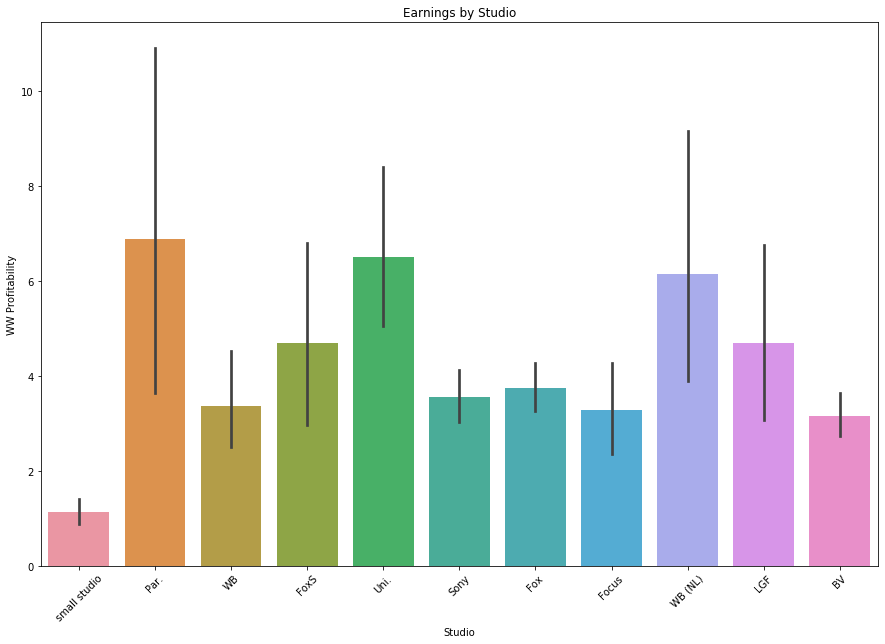

In [41]:
#create plot of earnings by studio
plt.figure(figsize=(15,10))
ax1 = sns.barplot('studio', 'Worldwide Profitability', data=biggest_studios_df)
plt.title('Earnings by Studio')
plt.xlabel('Studio')
plt.xticks(rotation=45)
plt.ylabel('WW Profitability')
plt.show()

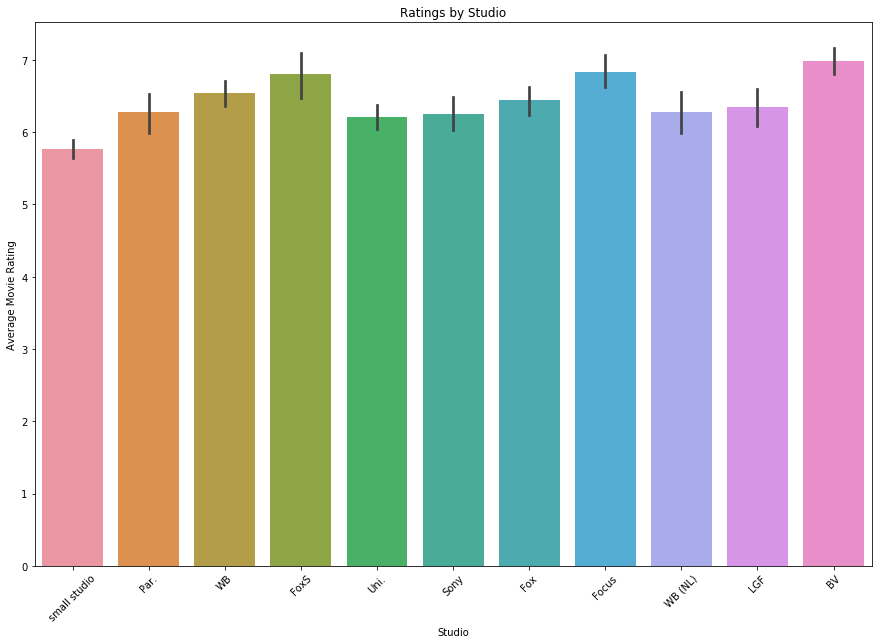

In [42]:
#create plot of ratings by studio
plt.figure(figsize=(15,10))
ax1 = sns.barplot('studio', 'averagerating', data=biggest_studios_df)
plt.title('Ratings by Studio')
plt.xlabel('Studio')
plt.xticks(rotation=45)
plt.ylabel('Average Movie Rating')
plt.show()

In [43]:
#create dictionary with values as genres
genre_dict={}
for i, genre in zip(range(len(genre_set)), genre_set):
        genre_dict[i]=[genre]

{0: [nan],
 1: ['Crime'],
 2: [None],
 3: ['Music'],
 4: ['Fantasy'],
 5: ['Family'],
 6: ['Sport'],
 7: ['War'],
 8: ['Animation'],
 9: ['News'],
 10: ['Game-Show'],
 11: ['Thriller'],
 12: ['Action'],
 13: ['Documentary'],
 14: ['Sci-Fi'],
 15: ['Reality-TV'],
 16: ['Biography'],
 17: ['Western'],
 18: ['Short'],
 19: ['Romance'],
 20: ['Musical'],
 21: ['Mystery'],
 22: ['Horror'],
 23: ['Drama'],
 24: ['Comedy'],
 25: ['Talk-Show'],
 26: ['Adult'],
 27: ['History'],
 28: ['Adventure']}

In [44]:
#append to dictionary values for average ratings and of worldwide profitability
for i in range(29):
    genre_df_current = main_df3[(main_df3['Genre 1']==genre_dict[i][0]) | (main_df3['Genre 2']==genre_dict[i][0]) | (main_df3['Genre 3']==genre_dict[i][0])]
    average_ratings = genre_df_current['averagerating'].median()
    worldwide_profitability = genre_df_current['Worldwide Profitability'].median()
    genre_dict[i].append(average_ratings)
    genre_dict[i].append(worldwide_profitability)


In [45]:
#exclude genres with no avilable data
for i in range(29):
    if str(genre_dict[i][1])=='nan':
        del genre_dict[i]
    else:
        pass
genre_dict

{1: ['Crime', 6.4, 1.3835807714285715],
 3: ['Music', 6.3, 2.3523288],
 4: ['Fantasy', 6.2, 2.0322858315686276],
 5: ['Family', 6.3, 2.0092608],
 6: ['Sport', 6.8, 1.230472555],
 7: ['War', 6.449999999999999, 0.6089239027777777],
 8: ['Animation', 6.7, 2.7798676590909093],
 11: ['Thriller', 6.2, 2.2393101953846153],
 12: ['Action', 6.3, 2.1314258733333333],
 13: ['Documentary', 7.3, 1.49166775],
 14: ['Sci-Fi', 6.45, 2.587989810714286],
 16: ['Biography', 7.1, 1.831969397574124],
 17: ['Western', 6.5, 0.7242810937499999],
 19: ['Romance', 6.3, 2.260071219607843],
 20: ['Musical', 5.9, 0.102649],
 21: ['Mystery', 6.3, 2.6426119699699697],
 22: ['Horror', 5.7, 2.220753473809524],
 23: ['Drama', 6.6, 1.6434994416666666],
 24: ['Comedy', 6.3, 2.254639607142857],
 27: ['History', 7.0, 1.2581193444444443],
 28: ['Adventure', 6.5, 2.537862753397467]}

In [46]:
#create dataframe based on genre dictionary
main_genre_df = pd.DataFrame.from_dict(genre_dict, orient='index',columns=['Genre', 'Average Ratings', 'Worldwide Profitability'])
main_genre_df       

,Genre,Average Ratings,Worldwide Profitability
1,Crime,6.40,1.383581
3,Music,6.30,2.352329
4,Fantasy,6.20,2.032286
5,Family,6.30,2.009261
6,Sport,6.80,1.230473
7,War,6.45,0.608924
8,Animation,6.70,2.779868
11,Thriller,6.20,2.239310
12,Action,6.30,2.131426
13,Documentary,7.30,1.491668


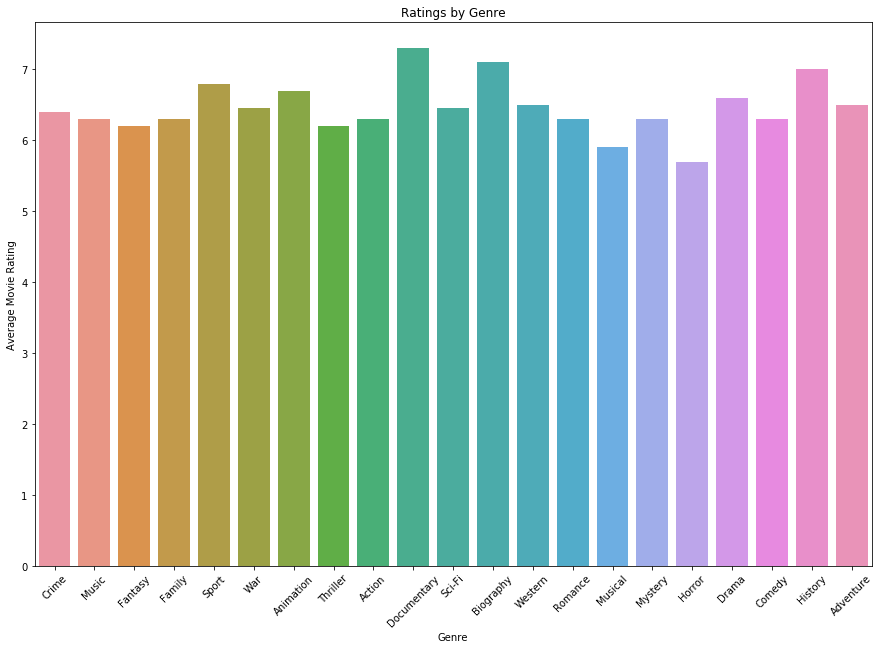

In [47]:
#plot median rating by genre
plt.figure(figsize=(15,10))
ax1 = sns.barplot('Genre', 'Average Ratings', data=main_genre_df)
plt.title('Ratings by Genre')
plt.xlabel('Genre')
plt.xticks(rotation=45)
plt.ylabel('Average Movie Rating')
plt.show()

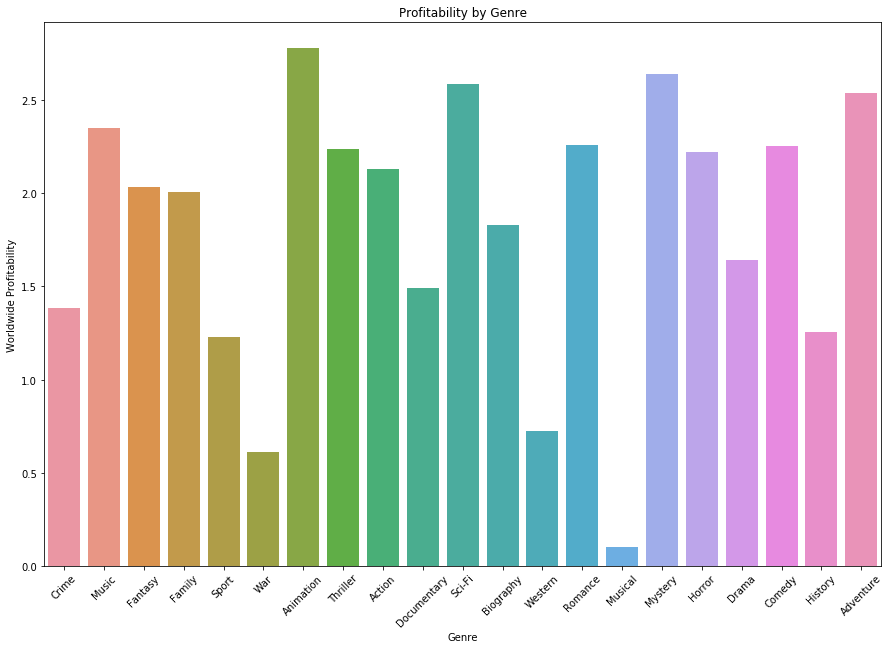

In [48]:
#plot median earnings by genre
plt.figure(figsize=(15,10))
ax1 = sns.barplot('Genre', 'Worldwide Profitability', data=main_genre_df)
plt.title('Profitability by Genre')
plt.xlabel('Genre')
plt.xticks(rotation=45)
# plt.ylabel('Worldwide Profitability')
plt.show()